# библиотеки

In [ ]:
!pip install pyheif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 3.3 MB/s 


In [ ]:
# !pip install catboost

In [ ]:
import pandas as pd
import os
import numpy as np
import pyheif 
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt # Отображение графиков
import seaborn as sns
from tensorflow.keras.preprocessing import image 
from PIL import Image

from IPython.display import clear_output 
from tensorflow.keras.utils import plot_model 

import numpy as np                                # Numpy массивы
import pandas as pd                               # Библиотека pandas
import time                                       # Импортируем библиотеку time
import random  

import os                                         # Для работы с файлами 
import gc                                         # сборщик мусора, gc.collect()
import cv2

from google.colab import files

# from catboost import CatBoostRegressor

import tensorflow as tf

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model # 
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Activation #
from tensorflow.keras.layers import Reshape, Conv1D, MaxPooling1D, AveragePooling1D, GlobalMaxPool1D
from tensorflow.keras.activations import relu, elu, softmax, softplus
from keras.layers.advanced_activations import LeakyReLU

from tensorflow.keras import utils                                       #Используем для to_categoricall
from tensorflow.keras.optimizers import Nadam, Adam, Adadelta, SGD, Adagrad, RMSprop

import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


# Данные

In [ ]:
# BATCH_SIZE = 8

img_width = 480
img_height = 360
channels = 3 
images_size = (img_width, img_height)  # размер изображений, которые будут подаваться в модель

In [ ]:
Path = '/content/drive/My Drive/Ульяновск/'
imagesTrainDirPath = '/content/drive/My Drive/Ульяновск/train/'
images_TestDirPath = '/content/drive/My Drive/Ульяновск/test/'

imagesTrainList = sorted(os.listdir(imagesTrainDirPath))
images_TestList = sorted(os.listdir(images_TestDirPath))

In [ ]:
test_img_names = set(os.listdir(images_TestDirPath))
train_img_names = set(os.listdir(imagesTrainDirPath))

print(len(test_img_names))
print(len(train_img_names))

521
530


In [ ]:
imagesTrainList

['img_1596.jpg',
 'img_1600.jpg',
 'img_1601.jpg',
 'img_1603.jpg',
 'img_1605.jpg',
 'img_1606.jpg',
 'img_1607.jpg',
 'img_1608.jpg',
 'img_1612.jpg',
 'img_1613.jpg',
 'img_1615.jpg',
 'img_1616.jpg',
 'img_1618.jpg',
 'img_1619.jpg',
 'img_1620.jpg',
 'img_1621.jpg',
 'img_1623.jpg',
 'img_1626.jpg',
 'img_1627.jpg',
 'img_1628.jpg',
 'img_1631.jpg',
 'img_1634.jpg',
 'img_1635.jpg',
 'img_1637.jpg',
 'img_1640.jpg',
 'img_1641.jpg',
 'img_1643.jpg',
 'img_1645.jpg',
 'img_1647.jpg',
 'img_1649.jpg',
 'img_1650.jpg',
 'img_1653.jpg',
 'img_1656.jpg',
 'img_1658.jpg',
 'img_1662.jpg',
 'img_1665.jpg',
 'img_1666.jpg',
 'img_1667.jpg',
 'img_1672.jpg',
 'img_1673.jpg',
 'img_1674.jpg',
 'img_1675.jpg',
 'img_1676.jpg',
 'img_1677.jpg',
 'img_1680.jpg',
 'img_1681.jpg',
 'img_1684.jpg',
 'img_1685.jpg',
 'img_1686.jpg',
 'img_1687.jpg',
 'img_1688.jpg',
 'img_1690.jpg',
 'img_1691.jpg',
 'img_1692.jpg',
 'img_1696.jpg',
 'img_1700.jpg',
 'img_1707.jpg',
 'img_1708.jpg',
 'img_1709.jpg

# Сервисные Функции

In [ ]:
def predTrain(model_reg):
  from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
  from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error

  predTr = model_reg.predict(train_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']])

  df = train_df[['distance']]
  df['pred'] = predTr
  print(df.head(3))

  r2 = r2_score(df[['distance']].values, df['pred'].values)
  print('R2 на ОБУЧЕНИИ:  ', r2)
  

In [ ]:
def PredTEST(model_reg, name = '2'):
  test_df = pd.read_csv('/content/drive/My Drive/Ульяновск/test_df.csv')
  XTEST = test_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']].values
  
  preds = model_reg.predict(XTEST)

  test_df['distance'] = preds
  sample_solution_df = test_df[['image_name', 'distance']]

  # Если НЕ все Идентифицировали
  lost_test_items = []
  for file_name in test_img_names - set(sample_solution_df['image_name'].values):
    lost_test_items.append([file_name, np.mean(sample_solution_df['distance'].values)])
  if len(lost_test_items) > 0:
    lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
    sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])


  sample_solution_df.to_csv(f'sample_solution{name}.csv', sep=';', index=False)
  files.download(f'sample_solution{name}.csv')

  

In [ ]:
def PredTEST_dop(model_reg, XTEST, name = '2'):
  # test_df = pd.read_csv('/content/drive/My Drive/Ульяновск/test_df.csv')
  # XTEST = test_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']].values
  
  preds = model_reg.predict(XTEST)

  test_df['distance'] = preds
  sample_solution_df = test_df[['image_name', 'distance']]

  # Если НЕ все Идентифицировали
  lost_test_items = []
  for file_name in test_img_names - set(sample_solution_df['image_name'].values):
    lost_test_items.append([file_name, np.mean(sample_solution_df['distance'].values)])
  if len(lost_test_items) > 0:
    lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
    sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])


  sample_solution_df.to_csv(f'sample_solution{name}.csv', sep=';', index=False)
  files.download(f'sample_solution{name}.csv')


In [ ]:
def pltFigure(history_, loss = 'loss', val_loss ='val_loss'):
  plt.figure(1, figsize=(18, 4))
  
  plt.plot(history_.history[loss], 
         label='на обучающем наборе')
  plt.plot(history_.history[val_loss], 
         label=f"на проверочном наборе, {round(history_.history[val_loss][-1], 5)}")
  plt.xlabel('Эпоха обучения')
  plt.ylabel(loss)
  plt.legend()
  plt.show()

# Загружаем Xtrain и Test

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Ульяновск/Xtest_df.csv')

test_df13 = pd.read_csv('/content/drive/My Drive/Ульяновск/Xtest_df13.csv')
test_df13

,image_name,x_min,y_min,x_max,y_max,lenBB,lenSetCrossover,rate,rest,diff,x,y,S,P
0,img_1597.jpg,0.386701,0.365357,0.590218,0.611303,8.910,2.903,0.168779,14.297,0.388697,0.203517,0.245946,0.050054,0.898926
1,img_1598.jpg,0.345702,0.363452,0.627653,0.682264,15.892,4.686,0.272442,12.514,0.317736,0.281950,0.318812,0.089889,1.201525
2,img_1599.jpg,0.286587,0.342595,0.653933,0.746866,25.842,6.633,0.385640,10.567,0.253134,0.367346,0.404271,0.148507,1.543233
3,img_1602.jpg,0.333478,0.371469,0.628751,0.724851,18.176,5.923,0.344360,11.277,0.275149,0.295273,0.353383,0.104344,1.297312
4,img_1604.jpg,0.236098,0.345266,0.747414,0.922700,51.414,13.587,0.789942,3.613,0.077300,0.511316,0.577434,0.295251,2.177500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,img_2936.jpg,0.352669,0.401237,0.613869,0.689762,13.230,4.923,0.286221,12.277,0.310238,0.261200,0.288525,0.075363,1.099450
516,img_2938.jpg,0.300101,0.302763,0.694212,0.745660,30.590,6.633,0.385640,10.567,0.254340,0.394110,0.442896,0.174550,1.674013
517,img_2942.jpg,0.371404,0.368534,0.531411,0.552984,5.304,1.456,0.084651,15.744,0.447016,0.160008,0.184450,0.029513,0.688914
518,img_2943.jpg,0.404168,0.372404,0.549071,0.542147,4.340,1.458,0.084767,15.742,0.457853,0.144903,0.169743,0.024596,0.629293


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Ульяновск/Xtrain_df.csv')

train_df13 = pd.read_csv('/content/drive/My Drive/Ульяновск/Xtrain_df13.csv')
train_df13

,image_name,distance,x_min,y_min,x_max,y_max,lenBB,lenSetCrossover,rate,rest,diff,x,y,S,P
0,img_1596.jpg,4.88,0.412538,0.388553,0.566105,0.568474,4.884,1.943,0.112965,15.257,0.431526,0.153566,0.179921,0.027630,0.666974
1,img_1600.jpg,1.54,0.279235,0.393212,0.749774,0.900966,41.584,12.593,0.732151,4.607,0.099034,0.470539,0.507754,0.238918,1.956586
2,img_1601.jpg,3.68,0.390106,0.406447,0.603662,0.668035,9.785,4.303,0.250174,12.897,0.331965,0.213557,0.261589,0.055864,0.950290
3,img_1603.jpg,2.22,0.310886,0.351932,0.671392,0.768329,26.274,7.379,0.429012,9.821,0.231671,0.360506,0.416396,0.150113,1.553805
4,img_1605.jpg,3.73,0.399225,0.372098,0.613761,0.637100,10.088,3.506,0.203837,13.694,0.362900,0.214536,0.265003,0.056853,0.959076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,img_2939.jpg,3.00,0.371811,0.354090,0.592888,0.600996,9.630,2.649,0.154012,14.551,0.399004,0.221076,0.246906,0.054585,0.935966
526,img_2940.jpg,3.46,0.391498,0.342250,0.586167,0.566273,7.695,1.888,0.109767,15.312,0.433727,0.194669,0.224022,0.043610,0.837384
527,img_2941.jpg,3.91,0.378916,0.399752,0.553656,0.601431,6.290,2.592,0.150698,14.608,0.398569,0.174740,0.201679,0.035241,0.752839
528,img_2944.jpg,5.20,0.387023,0.412049,0.524187,0.569887,3.886,1.528,0.088837,15.672,0.430113,0.137163,0.157838,0.021650,0.590003


In [ ]:
train_df

,image_name,distance,x_min,y_min,x_max,y_max,lenBB,lenSetCrossover,rate,rest,diff
0,img_1596.jpg,4.88,0.412538,0.388553,0.566105,0.568474,4.884,1.943,0.112965,15.257,0.431526
1,img_1600.jpg,1.54,0.279235,0.393212,0.749774,0.900966,41.584,12.593,0.732151,4.607,0.099034
2,img_1601.jpg,3.68,0.390106,0.406447,0.603662,0.668035,9.785,4.303,0.250174,12.897,0.331965
3,img_1603.jpg,2.22,0.310886,0.351932,0.671392,0.768329,26.274,7.379,0.429012,9.821,0.231671
4,img_1605.jpg,3.73,0.399225,0.372098,0.613761,0.637100,10.088,3.506,0.203837,13.694,0.362900
...,...,...,...,...,...,...,...,...,...,...,...
525,img_2939.jpg,3.00,0.371811,0.354090,0.592888,0.600996,9.630,2.649,0.154012,14.551,0.399004
526,img_2940.jpg,3.46,0.391498,0.342250,0.586167,0.566273,7.695,1.888,0.109767,15.312,0.433727
527,img_2941.jpg,3.91,0.378916,0.399752,0.553656,0.601431,6.290,2.592,0.150698,14.608,0.398569
528,img_2944.jpg,5.20,0.387023,0.412049,0.524187,0.569887,3.886,1.528,0.088837,15.672,0.430113


In [ ]:
xTrain8 = train_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']].values

xTrain = train_df.drop(columns=['image_name', 'distance']).values
print(xTrain.shape, '\n')

xTrain13 = train_df13.drop(columns=['image_name', 'distance']).values
xTrain13.shape

(530, 9) 



(530, 13)

In [ ]:
yTrain = train_df[['distance']].values
yTrain.shape

(530, 1)

In [ ]:
# xTrain7 = train_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate']].values
# xTrain7.shape

In [ ]:
# xTrain5 = train_df[['y_min','y_max', "lenBB",	'lenSetCrossover', 'rate']].values
# xTrain5.shape

In [ ]:
# xTrain4 = train_df[['y_min',"lenBB",	'lenSetCrossover', 'rate']].values
# xTrain4.shape

In [ ]:
Xtest = test_df.drop(columns=['image_name']).values

print(Xtest.shape)

Xtest13 = test_df13.drop(columns=['image_name']).values

Xtest13.shape

(520, 9)


(520, 13)

# Callback , metrics

In [ ]:
from tensorflow.keras import backend as K

def scoreR2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

from sklearn.metrics import r2_score
def r2_score(y_test, predict ):
    return r2_score(y_test, predict)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

patch = '/content/drive/My Drive/Ульяновск/'
model_checkpointMAE = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsMAE.h5'), 
                                   monitor='val_MAE', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='min')   # mode='auto'

model_checkpointLoss = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsLoss.h5'), 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='min')   # mode='auto'

model_checkpointMSE = ModelCheckpoint(filepath=os.path.join(patch, 'model_weightsMSE.h5'), 
                                   monitor='val_MSE', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True,  # СОХРАНЯЕМ ВЕСА Модели
                                   mode='min')   # mode='auto'

# patchMod = '/content/drive/My Drive/Ярославль/model_weightsUnet.h5'
# callbacks=[model_checkpoint]

In [ ]:
# https://keras.io/examples/structured_data/imbalanced_classification/
from tensorflow.keras.metrics import MeanIoU, MeanAbsoluteError, MeanSquaredError, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall

metrics = [
    # MeanIoU(num_classes = 3, name="MeanIoU"),
    MeanAbsoluteError(name="MAE"),
    MeanSquaredError(name="MSE")
    ]

# 2Bloka №7  _ mse = 0.1453  > Score = 0.927133

x_min,	y_min,	x_max,	y_max,	lenBB,	lenSetCrossover,	rate,	diff

In [ ]:
print(xTrain.shape)
print(yTrain.shape)

(530, 8)
(530, 1)


In [ ]:
def Create_DenseNet(shape = (8,)):

    input = Input(shape)

    x1 = Dense(1024, activation='relu') (input)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, activation='sigmoid')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(64, activation='sigmoid')(x1)
    

    x5 = Dense(256)(input)
    x5 = BatchNormalization()(x5)
    x5 = Activation("sigmoid")(x5)

    x = concatenate([input, x1, x5])

    x = Dense(512, activation='sigmoid')(x)
    x = Dropout(0.2)(x)

    out = Dense(1, activation='linear')(x)

    model = Model(input, out)

    model.compile(optimizer=SGD(learning_rate=1e-3), 
                  loss='mse',        # 'mse'   , tf.keras.losses.MeanSquaredLogarithmicError()
                  metrics=[scoreR2, metrics])
    return model  

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_32 (Dense)               (None, 1024)         9216        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 1024)        4096        ['dense_32[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_16 (Dropout)           (None, 1024)         0           ['batch_normalization_19[0]

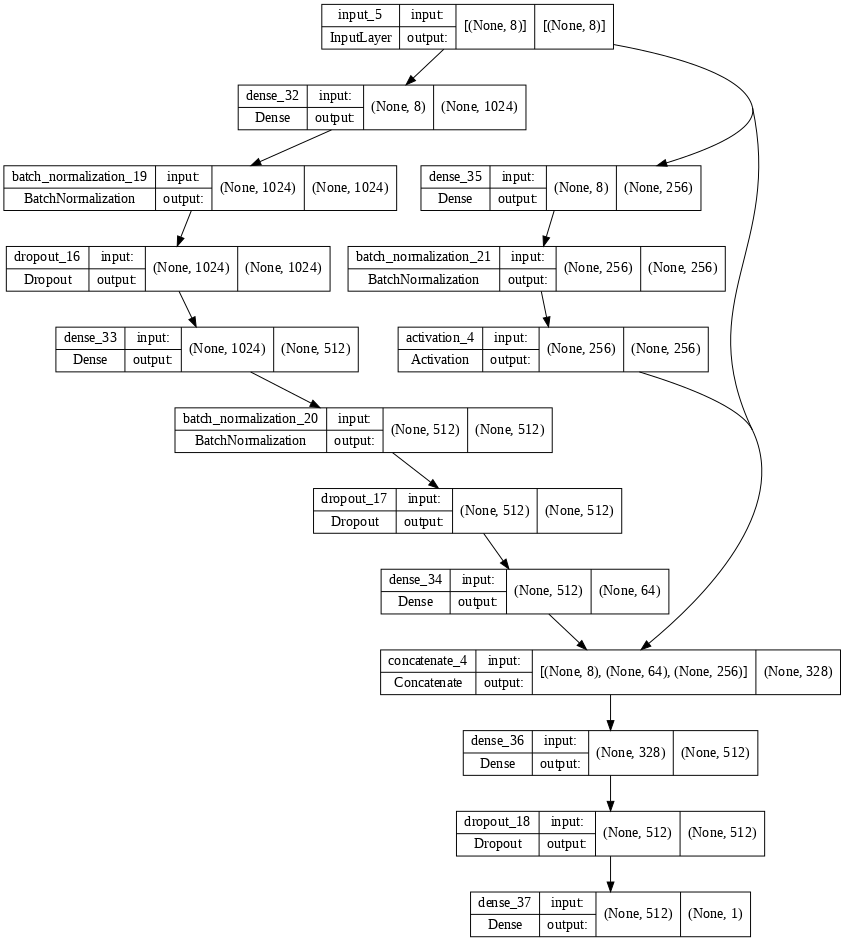

In [ ]:
model = Create_DenseNet()

model.summary()
print()
plot_model(model, dpi=70, show_shapes=True )

In [ ]:
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=100, 
                    validation_split=0.15,
                    verbose=1,                                                          # batch_size=128
                    callbacks=[model_checkpointMAE, model_checkpointMSE, model_checkpointLoss])       

Epoch 1/100
13/15 [=========================>....] - ETA: 0s - loss: 4.8858 - scoreR2: -0.5460 - MAE: 1.7196 - MSE: 4.8858
Epoch 1: val_MAE improved from inf to 1.13236, saving model to /content/drive/My Drive/Ульяновск/model_weightsMAE.h5

Epoch 1: val_MSE improved from inf to 1.88598, saving model to /content/drive/My Drive/Ульяновск/model_weightsMSE.h5

Epoch 1: val_loss improved from inf to 1.88598, saving model to /content/drive/My Drive/Ульяновск/model_weightsLoss.h5
15/15 [==============================] - 3s 125ms/step - loss: 4.7968 - scoreR2: -0.4573 - MAE: 1.7098 - MSE: 4.7968 - val_loss: 1.8860 - val_scoreR2: -0.0037 - val_MAE: 1.1324 - val_MSE: 1.8860
Epoch 2/100
13/15 [=========================>....] - ETA: 0s - loss: 2.4738 - scoreR2: 0.2192 - MAE: 1.2758 - MSE: 2.4738
Epoch 2: val_MAE improved from 1.13236 to 0.93504, saving model to /content/drive/My Drive/Ульяновск/model_weightsMAE.h5

Epoch 2: val_MSE improved from 1.88598 to 1.34731, saving model to /content/drive/M

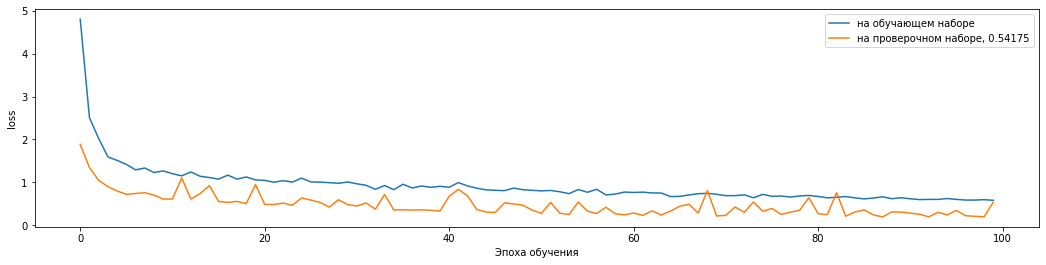

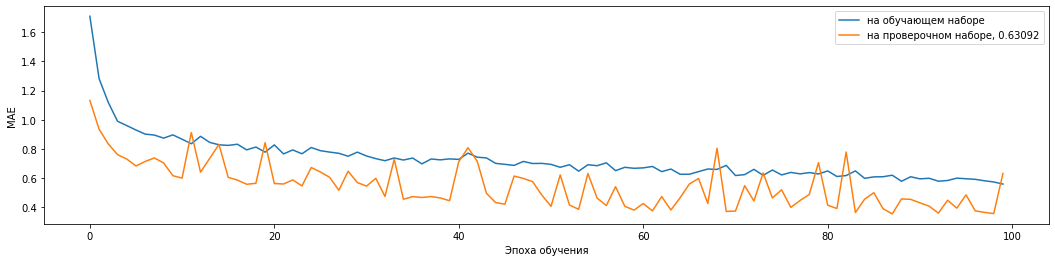

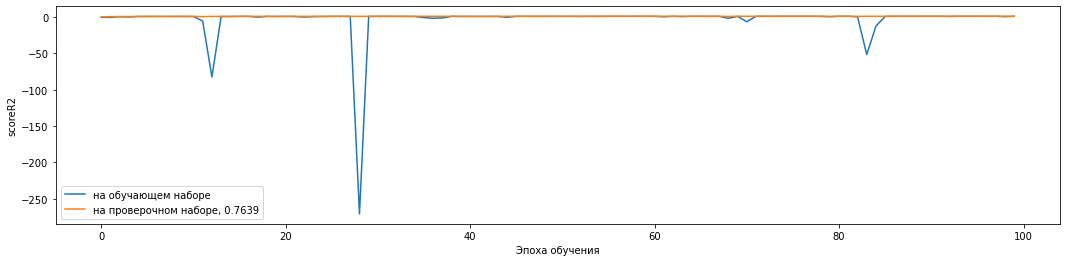

In [ ]:
pltFigure(history,'loss', 'val_loss')
pltFigure(history,'MAE', 'val_MAE')
pltFigure(history,'scoreR2', 'val_scoreR2')


ДООБУЧЕНИЕ - Изменение lr

In [ ]:
model.compile(optimizer=Adam(0.00099), 
                  loss='mse',  # 'mse', 
                  metrics=[scoreR2, metrics])

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=300, 
                    validation_split=0.15,
                    verbose=1,
                    initial_epoch = 100,   # batch_size=128
                    callbacks=[model_checkpointMAE, model_checkpointMSE, model_checkpointLoss])   

Epoch 101/300
15/15 [==============================] - ETA: 0s - loss: 0.7248 - scoreR2: 0.3932 - MAE: 0.6434 - MSE: 0.6972
Epoch 101: val_MAE did not improve from 0.35345

Epoch 101: val_MSE did not improve from 0.19948

Epoch 101: val_loss did not improve from 0.19948
15/15 [==============================] - 2s 40ms/step - loss: 0.7248 - scoreR2: 0.3932 - MAE: 0.6434 - MSE: 0.6972 - val_loss: 0.3721 - val_scoreR2: 0.8414 - val_MAE: 0.4763 - val_MSE: 0.3721
Epoch 102/300
13/15 [=========================>....] - ETA: 0s - loss: 0.5331 - scoreR2: 0.8253 - MAE: 0.5364 - MSE: 0.5331
Epoch 102: val_MAE improved from 0.35345 to 0.34729, saving model to /content/drive/My Drive/Ульяновск/model_weightsMAE.h5

Epoch 102: val_MSE did not improve from 0.19948

Epoch 102: val_loss did not improve from 0.19948
15/15 [==============================] - 0s 21ms/step - loss: 0.5165 - scoreR2: 0.8406 - MAE: 0.5302 - MSE: 0.5165 - val_loss: 0.2160 - val_scoreR2: 0.8811 - val_MAE: 0.3473 - val_MSE: 0.2160

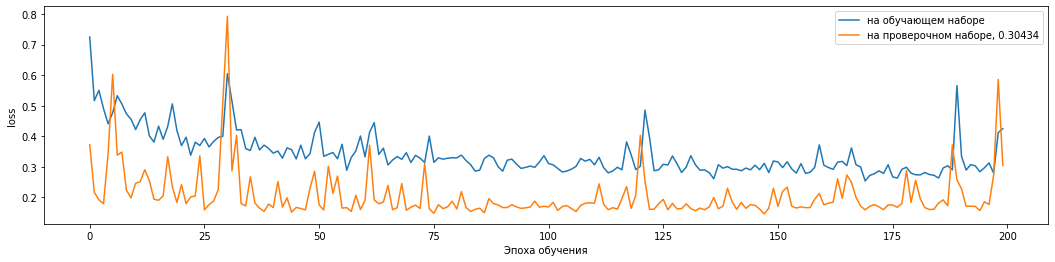

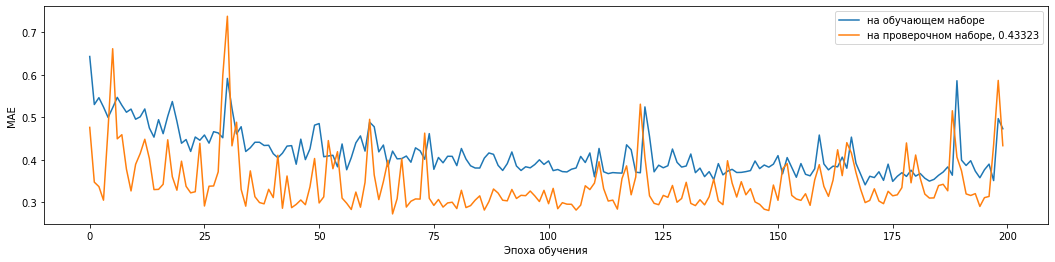

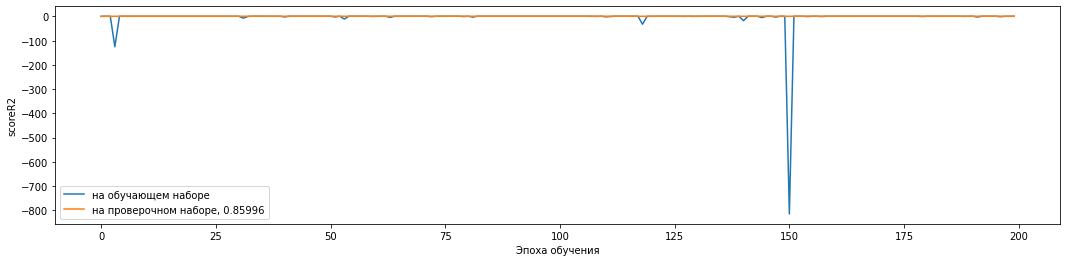

In [ ]:
pltFigure(history,'loss', 'val_loss')
pltFigure(history,'MAE', 'val_MAE')
pltFigure(history,'scoreR2', 'val_scoreR2')


In [ ]:
model.compile(optimizer=SGD(0.000115), 
                  loss='mse',  # 'mse', 
                  metrics=[scoreR2, metrics])

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=300, 
                    validation_split=0.15,
                    verbose=1,
                    initial_epoch = 100,   # batch_size=128
                    callbacks=[model_checkpointMAE, model_checkpointMSE, model_checkpointLoss])  

Epoch 101/300
13/15 [=========================>....] - ETA: 0s - loss: 0.2024 - scoreR2: 0.9354 - MAE: 0.3226 - MSE: 0.1971
Epoch 101: val_MAE did not improve from 0.27245

Epoch 101: val_MSE did not improve from 0.14530

Epoch 101: val_loss did not improve from 0.14530
15/15 [==============================] - 2s 33ms/step - loss: 0.2007 - scoreR2: 0.9078 - MAE: 0.3211 - MSE: 0.1959 - val_loss: 0.1685 - val_scoreR2: 0.8998 - val_MAE: 0.3053 - val_MSE: 0.1685
Epoch 102/300
13/15 [=========================>....] - ETA: 0s - loss: 0.2134 - scoreR2: 0.9270 - MAE: 0.3378 - MSE: 0.2134
Epoch 102: val_MAE did not improve from 0.27245

Epoch 102: val_MSE did not improve from 0.14530

Epoch 102: val_loss did not improve from 0.14530
15/15 [==============================] - 0s 18ms/step - loss: 0.2117 - scoreR2: 0.9108 - MAE: 0.3358 - MSE: 0.2117 - val_loss: 0.1688 - val_scoreR2: 0.9008 - val_MAE: 0.3073 - val_MSE: 0.1688
Epoch 103/300
13/15 [=========================>....] - ETA: 0s - loss: 0.1

In [ ]:
model.compile(optimizer=Adam(0.000001), 
                  loss='mse',  # 'mse', 
                  metrics=[scoreR2, metrics])

history = model.fit(xTrain, 
                    yTrain, 
                    epochs=300, 
                    validation_split=0.15,
                    verbose=1,
                    initial_epoch = 100,   # batch_size=128
                    callbacks=[model_checkpointMAE, model_checkpointMSE, model_checkpointLoss])  

Epoch 101/300
14/15 [===========================>..] - ETA: 0s - loss: 0.1879 - scoreR2: 0.9361 - MAE: 0.3227 - MSE: 0.1893
Epoch 101: val_MAE did not improve from 0.27245

Epoch 101: val_MSE did not improve from 0.14530

Epoch 101: val_loss did not improve from 0.14530
15/15 [==============================] - 4s 59ms/step - loss: 0.1875 - scoreR2: 0.9370 - MAE: 0.3225 - MSE: 0.1889 - val_loss: 0.1970 - val_scoreR2: 0.8939 - val_MAE: 0.3453 - val_MSE: 0.1970
Epoch 102/300
13/15 [=========================>....] - ETA: 0s - loss: 0.1918 - scoreR2: 0.9386 - MAE: 0.3259 - MSE: 0.1918
Epoch 102: val_MAE did not improve from 0.27245

Epoch 102: val_MSE did not improve from 0.14530

Epoch 102: val_loss did not improve from 0.14530
15/15 [==============================] - 0s 18ms/step - loss: 0.2095 - scoreR2: 0.9270 - MAE: 0.3248 - MSE: 0.2095 - val_loss: 0.1961 - val_scoreR2: 0.8943 - val_MAE: 0.3447 - val_MSE: 0.1961
Epoch 103/300
12/15 [=======================>......] - ETA: 0s - loss: 0.1

In [ ]:
model.load_weights('/content/drive/My Drive/Ульяновск/model_weightsLoss.h5')

PredTEST(model,'2bloka_7')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**> Score = 0.927133**

In [ ]:
# model.save_weights('/content/drive/My Drive/Ульяновск/model_weights_Score_0.927133.h5')

# CBR №1 > Score = 0.918399

In [ ]:
from catboost import CatBoostRegressor

learn: 0.1793737

In [ ]:
model_CBR = CatBoostRegressor()

# Fit model
model_CBR.fit(train_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']], 
              train_df[['distance']].values)

Learning rate set to 0.037035
0:	learn: 1.7126567	total: 4.92ms	remaining: 4.92s
1:	learn: 1.6642667	total: 7.94ms	remaining: 3.96s
2:	learn: 1.6196546	total: 10.9ms	remaining: 3.63s
3:	learn: 1.5798338	total: 14.1ms	remaining: 3.5s
4:	learn: 1.5387380	total: 17.9ms	remaining: 3.57s
5:	learn: 1.4955375	total: 20.7ms	remaining: 3.43s
6:	learn: 1.4555274	total: 23.5ms	remaining: 3.33s
7:	learn: 1.4169672	total: 26.5ms	remaining: 3.29s
8:	learn: 1.3797432	total: 30.5ms	remaining: 3.36s
9:	learn: 1.3448109	total: 33.3ms	remaining: 3.3s
10:	learn: 1.3134603	total: 35.9ms	remaining: 3.23s
11:	learn: 1.2835291	total: 38.6ms	remaining: 3.18s
12:	learn: 1.2526950	total: 41.3ms	remaining: 3.13s
13:	learn: 1.2238890	total: 44.1ms	remaining: 3.1s
14:	learn: 1.1976185	total: 47.4ms	remaining: 3.11s
15:	learn: 1.1708964	total: 50.3ms	remaining: 3.09s
16:	learn: 1.1435669	total: 53.1ms	remaining: 3.07s
17:	learn: 1.1171871	total: 55.8ms	remaining: 3.04s
18:	learn: 1.0938027	total: 58.5ms	remaining: 3

## predTest

In [ ]:
preds = model_CBR.predict(test_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']])

test_df['distance'] = preds

test_df.head(3)

,image_name,x_min,y_min,x_max,y_max,lenBB,lenSetCrossover,rate,diff,distance
0,img_2413.jpg,0.001698,0.425614,0.304262,0.679423,7.500,3.601,0.209360,0.320577,3.631460
1,img_1953.jpg,0.428661,0.449516,0.516608,0.545690,1.548,1.012,0.058837,0.454310,7.356510
2,img_2499.jpg,0.378356,0.382649,0.581928,0.615906,8.415,2.968,0.172558,0.384094,2.963908


In [ ]:
sample_solution_df = test_df[['image_name', 'distance']]

In [ ]:
sample_solution_df

,image_name,distance
0,img_2413.jpg,3.631460
1,img_1953.jpg,7.356510
2,img_2499.jpg,2.963908
3,img_2537.jpg,2.911734
4,img_2375.jpg,2.295505
...,...,...
515,img_2428.jpg,2.991208
516,img_1877.jpg,8.276188
517,img_2393.jpg,3.089925
518,img_2749.jpg,4.098737


In [ ]:
np.mean(sample_solution_df['distance'].values)

4.189862048205612

In [ ]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
  lost_test_items.append([file_name, np.mean(sample_solution_df['distance'].values)])

In [ ]:
lost_test_items

[['img_2674.heic', 4.189862048205612]]

In [ ]:
lost_test_items[0][0]

'img_2674.heic'

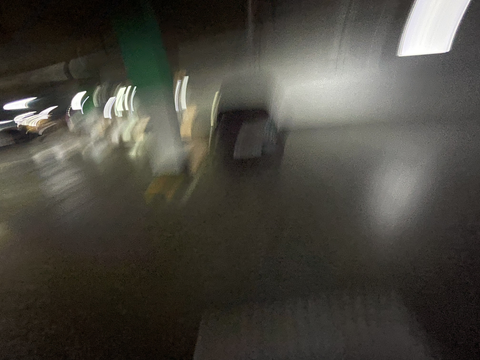

In [ ]:
heif_file = pyheif.read(os.path.join(images_TestDirPath, lost_test_items[0][0]))
img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
img.thumbnail(images_size, Image.ANTIALIAS)
img

In [ ]:
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
lost_test_items_df

,image_name,distance
0,img_2674.heic,4.189862


In [ ]:
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

In [ ]:
sample_solution_df.to_csv('sample_solution.csv', sep=';', index=False)
files.download('sample_solution.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**> Score = 0.918399**

In [ ]:
model_CBR.save_model('/content/drive/My Drive/Ульяновск/model_CBR',
           format="cbm",
           export_parameters=None,
           pool=None)

# Загрузка
# reg = CatBoostRegressor()
# reg.load_model("model")
# reg.load_model('/content/drive/My Drive/Ульяновск/model_CBR')

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error


In [ ]:
predTr = model_CBR.predict(train_df[['x_min', 'y_min', 'x_max', 'y_max', "lenBB",	'lenSetCrossover', 'rate', 'diff']])

In [ ]:
# metrics = {}

# metrics['mape'] = mean_absolute_percentage_error(train_df[['distance']].values, 
#                                                  predTr)

# metrics['mae'] = mean_absolute_error(train_df[['distance']].values, 
#                                      predTr)

### r2_poisson = r2_score(actual_counts, predicted_counts_poisson)

# df_metrics = pd.DataFrame(metrics)
# df_metrics

In [ ]:
df = train_df[['distance']]
df['pred'] = predTr
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,distance,pred
0,4.88,4.586564
1,1.54,1.515953
2,3.68,3.710538
3,2.22,2.294017
4,3.73,3.665644
...,...,...
525,3.00,2.903886
526,3.46,3.499782
527,3.91,3.608046
528,5.20,5.191955


In [ ]:
r2 = r2_score(df[['distance']].values, df['pred'].values)
r2

0.9905347313285369

In [ ]:
model_CBR.get_best_score()

{'learn': {'RMSE': 0.17095061281062432}}

In [ ]:
model_CBR.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.03703499957919121,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fracti